In [86]:
import tensorflow as tf
import librosa
import numpy as np
import IPython.display as ipd
import os
import pandas as pd
import pyaudio
import wave
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import matplotlib.pyplot as plt

## Loading samples

In [6]:
X_start = []
paths = librosa.util.find_files(r'augmented')
for i in paths:
    x, sr = librosa.load(i)
    mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=len(x)//64, n_mfcc=20)
#     mfcc = mfcc.flatten()
    X_start.append(mfcc)

In [8]:
X_start_copy = np.array(X_start)
X_start_copy = X_start_copy.reshape(1278, 20, 65, 1)
y_start = np.ones(np.shape(X_start)[0])
np.shape(X_start_copy)

(1278, 20, 65, 1)

In [15]:
voices_path = r'audiobooks\data\ru_open_stt\private_buriy_audiobooks_2\0'

def kernel(paths):
    tmp = []
    for file in paths:
        x, sr = librosa.load(file)
        mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=len(x)//64, n_mfcc=20)
        tmp.append(mfcc)
    return tmp

pool = ThreadPool(len(os.listdir(voices_path)))
p = []
for path in os.listdir(voices_path):
    paths = librosa.util.find_files(voices_path + '\\' + path)
    p.append(paths)
X_other = pool.map(kernel, p)
pool.close()
pool.join()
np.shape(X_other)

(12,)

In [27]:
X_other_copy = []
for i in np.arange(12):
    for j in X_other[i]:
        X_other_copy.append(j)
np.shape(X_other_copy)
X_other = np.array(X_other_copy).reshape(3359, 20, 65, 1)
np.shape(X_other)

(3359, 20, 65, 1)

In [34]:
# X_other_copy = np.array(X_other)
# X_other_copy = x_other_copy.reshape()
y_other = np.zeros(np.shape(X_other)[0])
np.shape(X_other)

(3359, 20, 65, 1)

In [35]:
X = np.append(X_start_copy, X_other, axis=0)
Y = np.append(y_start, y_other, axis=0)
X_val = np.append(X[:120], X[-120:], axis=0)
X_train = X[120:-120]
Y_val = np.append(Y[:120], Y[-120:], axis=0)
Y_train = Y[120:-120]

In [37]:
X_val.shape

(240, 20, 65, 1)

In [832]:
X_val.reshape(240, 20, 65, 1)
X_train.reshape(240, 20, 65, 1)
X_val.reshape(240, 20, 65, 1)

(240, 20, 65)

In [57]:
X = pd.read_csv(r"data\\samples.csv", compression='zip', index_col=0)
Y = pd.read_csv(r"data\\samples_y.csv", compression='zip', index_col=0)

In [603]:
X_val = X[:120].append(X[-120:], ignore_index=True)
X_train = X[120:-120]
Y_val = Y[:120].append(Y[-120:], ignore_index=True)
Y_train = Y[120:-120]

## Preparing dataset

In [582]:
dataset = tf.data.Dataset.from_tensor_slices((X.values, Y.values))

In [583]:
shuffled_dataset = dataset.repeat().shuffle(len(X)).batch(128)

In [584]:
val_dataset = shuffled_dataset.take(700) 
train_dataset = shuffled_dataset.skip(700)

In [38]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).repeat().shuffle(len(X_val)).batch(32)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).repeat().shuffle(len(X_train)).batch(256)

In [ ]:
train_dataset

## Preparing model

In [78]:
model = tf.keras.Sequential([
#     tf.keras.layers.Dense(20, activation='relu', input_shape=(X.shape[1],)),
    #tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(20, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(20, 65, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [79]:
sgd = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

In [80]:
# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer=sgd,
#               metrics=['accuracy'])
model.compile(optimizer=sgd,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train model

In [130]:
model.fit(train_dataset, epochs=1, validation_data=val_dataset, steps_per_epoch=8, validation_steps=8)

Train for 8 steps, validate for 8 steps
8/8 [==============================] - 3s 423ms/step - loss: 0.6123 - accuracy: 0.9453 - val_loss: 0.6279 - val_accuracy: 0.9648


## Obtaining answer

#### Recording sample

In [204]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
RECORD_SECONDS = 1.5
WAVE_OUTPUT_FILENAME = "output.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


#### Sample processing

In [217]:
x, sr = librosa.load(r"audiobooks/data/ru_open_stt/private_buriy_audiobooks_2/0/1d/07921cf11da9.wav")
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=len(x)//64, n_mfcc=20)
# mfcc = mfcc.flatten()np.shape(X_other_copy)
print(mfcc.shape)

ipd.Audio(r"audiobooks/data/ru_open_stt/private_buriy_audiobooks_2/0/1d/07921cf11da9.wav", rate=sr)
# "WAVE_OUTPUT_FILENAME"
#r"audiobooks/data/ru_open_stt/private_buriy_audiobooks_2/0/1d/07921cf11da9.wav"

(20, 65)


#### Model testing

In [219]:
# model.predict(X.values[2200].reshape(1, X.shape[1])
model.predict(mfcc.reshape(1, 20, 65, 1))

array([[0.64096195, 0.35903805]], dtype=float32)

#### Saving model

In [129]:
model.save('models\\64_hop_20_nmfcc_CNN_v_2.h5')

In [214]:
mfcc = X_val[3].reshape(20, 65)

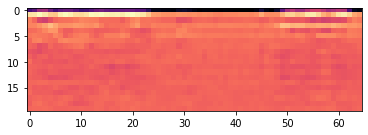

In [222]:
plt.imshow(mfcc, cmap='magma')

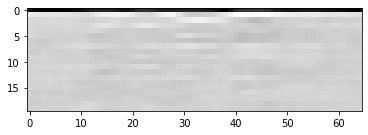

In [93]:
plt.imshow(mfcc, cmap='gray')

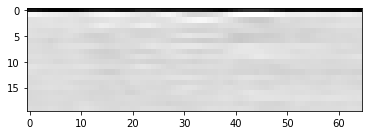

In [95]:
plt.imshow(mfcc, cmap='gray')

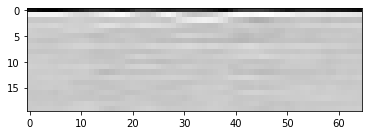

In [97]:
plt.imshow(mfcc, cmap='gray')